In [1]:
# Created: Dec. 17. 2018
# Use this notebook to restore saved tensorflow models.

In [114]:
import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [23]:
sys.path.append("../")

In [24]:
import hps_configs.mac_config as config
import core.tools.rnn_prepare as rnn_prepare
import constants

In [25]:
param = config.main

In [ ]:
param["LAGS"] = 3
param["num_neurons"] = (64, 128, 256)
param["learning_rate"] = 0.03

In [121]:
param["LAGS"] = 6
param["num_neurons"] = (256, 512)
param["learning_rate"] = 0.03

In [122]:
DIR = "/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/docs/demo source/demo2/meta"
META = "main.meta"
FILE_DIR = constants.DATA_DIR["a"]

In [123]:
tf.reset_default_graph()

In [124]:
prepared_df = rnn_prepare.prepare_dataset(
    file_dir=FILE_DIR,
    periods=param["PERIODS"],
    order=param["ORDER"],
    remove=None,
    verbose=False
)
(X_train, X_val, X_test,
 y_train, y_val, y_test) = rnn_prepare.split_dataset(
    raw=prepared_df,
    train_ratio=param["TRAIN_RATIO"],
    val_ratio=param["VAL_RATIO"],
    lags=param["LAGS"]
)
data_collection = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
StandardScaler applied, scaling based on the first 679 observations.
Total 842 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (842, 6, 1), y shape = (842, 1, 1)
Training and testing set generated,        
X_train shape: (672, 6, 1)        
y_train shape: (672, 1)        
X_test shape: (85, 6, 1)        
y_test shape: (85, 1)        
X_validation shape: (85, 6, 1)        
y_validation shape: (85, 1)


In [125]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph(DIR + "/" + META)
    saver.restore(sess, DIR + "/" + "main")
#     print(sess.run("DATA_FEED/Feature_X"))
    graph = tf.get_default_graph()
    X = graph.get_tensor_by_name("DATA_FEED/FEATURE:0")
    pred = graph.get_tensor_by_name("OUTPUT_LAYER/PREDICTION:0")
#     print(sess.run("OUTPUT_LAYER/Prediction"))

    def make_pred(feed_X):
        return pred.eval(feed_dict={X: feed_X})
    
    p_train = make_pred(X_train)
    p_val = make_pred(X_val)
    p_test = make_pred(X_test)

INFO:tensorflow:Restoring parameters from /Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/docs/demo source/demo2/meta/main


In [126]:
    # sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# imported_meta = tf.train.import_meta_graph(DIR + META)
# imported_meta.restore(sess, tf.train.latest_checkpoint(DIR))

In [127]:
trainable_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [128]:
print(len(prepared_df.index[param["LAGS"]+1:]))
t[:len(y_train)]

842


DatetimeIndex(['1948-06-01', '1948-07-01', '1948-08-01', '1948-09-01',
               '1948-10-01', '1948-11-01', '1948-12-01', '1949-01-01',
               '1949-02-01', '1949-03-01',
               ...
               '2003-08-01', '2003-09-01', '2003-10-01', '2003-11-01',
               '2003-12-01', '2004-01-01', '2004-02-01', '2004-03-01',
               '2004-04-01', '2004-05-01'],
              dtype='datetime64[ns]', name='DATE', length=672, freq=None)

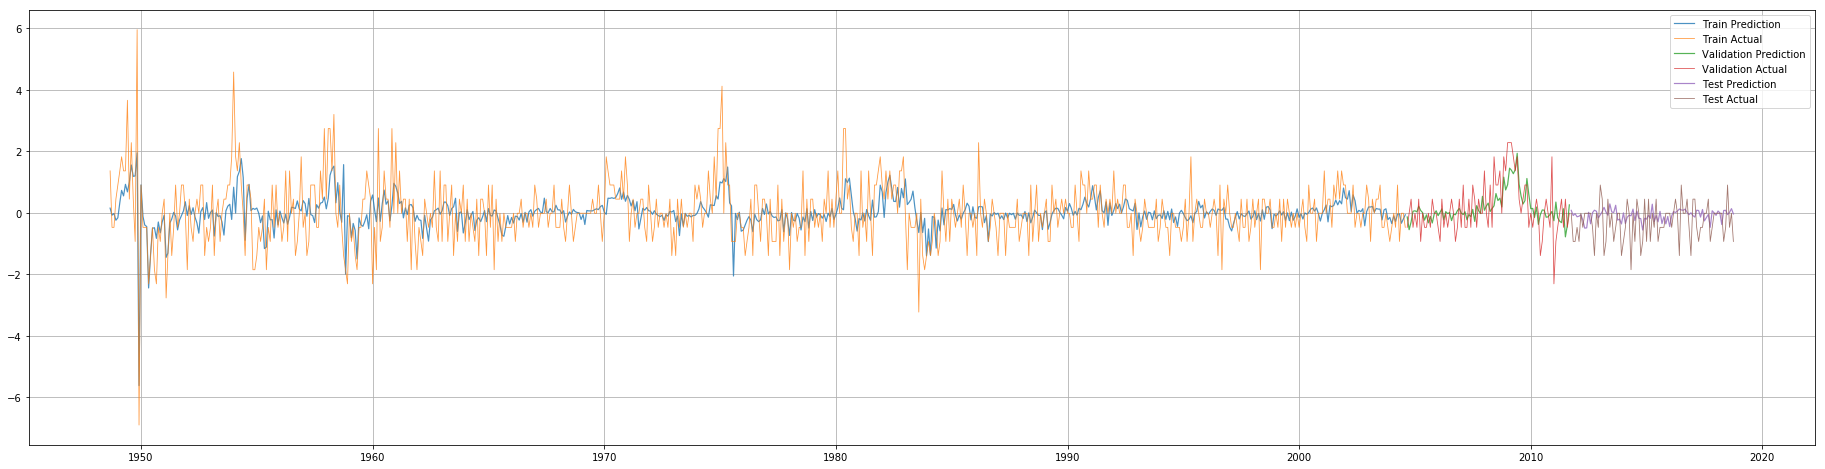

In [130]:
plt.close()
t = prepared_df.index[param["LAGS"]+1:]
train_rg = range(len(y_train))
val_rg = range(len(y_train), len(y_train) + len(y_val))
test_rg = range(len(y_train) + len(y_val), len(t))
plt.figure(figsize=(32,8))
plt.plot(t[train_rg], p_train, alpha=0.8, linewidth=1.2)
plt.plot(t[train_rg], y_train, alpha=0.8, linewidth=0.8)
plt.plot(t[val_rg], p_val, alpha=0.8, linewidth=1.2)
plt.plot(t[val_rg], y_val, alpha=0.8, linewidth=0.8)
plt.plot(t[test_rg], p_test, alpha=0.8, linewidth=1.2)
plt.plot(t[test_rg], y_test, alpha=0.8, linewidth=0.8)
plt.legend([
    "Train Prediction",
    "Train Actual",
    "Validation Prediction",
    "Validation Actual",
    "Test Prediction",
    "Test Actual"],
    loc="best"
)
plt.grid(True)
plt.savefig(DIR + "/" + "final_exclude_train.svg")